# Логистическая регрессия

In [101]:
from sklearn import datasets as dts
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn import linear_model
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import numpy as np
import scikitplot as skplt

In [102]:
def creat_graph(fpr, tpr, roc_auc):
    color_graph = ["black", "red", "orange", "yellow", "lime", "cyan", "steelblue"]
    plt.plot(fpr, tpr, color=color_graph[2],
        label= f'ROC кривая (area = {roc_auc:0.3f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Пример ROC-кривой')
    plt.legend(loc="lower right")
    plt.show()

In [103]:
def main():
    print("Лучшее обучение: ")
    for load_dataset, name_dts in [ (dts.load_iris, "Iris plants dataset"),
                        (dts.load_digits, "Optical recognition of handwritten digits dataset"),
                        (dts.load_wine,"Wine recognition dataset"),
                        (dts.load_breast_cancer, "Breast cancer wisconsin (diagnostic) dataset")]:

        x, y = make_classification(n_samples=10, random_state=0)
        data = load_dataset()
        x = data.data
        y = data.target
        # разделим данные с помощью Scikit-Learn's train_test_split
        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, random_state = 42)

        if name_dts == "Optical recognition of handwritten digits dataset":
            min_max_scaler = preprocessing.MinMaxScaler() # Создаем объект для нормализации
        else:
            min_max_scaler = preprocessing.QuantileTransformer(random_state=42) # Создаем объект для нормализации
        x_train = min_max_scaler.fit_transform(x_train)
        x_test = min_max_scaler.fit_transform(x_test)

        solvers = ["newton-cg", "lbfgs", "liblinear", "sag", "saga"] # Выбор решения.
        penaltys = ["l1", "l2", "elasticnet", "none"] # регуляризация, для решения вопроса переобучения.
        ratios = [x * 0.1 for x in range(1, 10)] # коэфы
        greatest_rez = [0, 0, 0, 0]

        for p in penaltys:
            for s in solvers:
                # Разбиваем параметры по поддержке
                if p == "l1":
                    clf = linear_model.LogisticRegression(penalty = p, n_jobs=None, solver = "liblinear", max_iter = 500).fit(x_train, y_train)
                elif p == "elasticnet":
                    for e in ratios:
                        clf = linear_model.LogisticRegression(penalty = p, n_jobs=None, solver = "saga", l1_ratio=e, max_iter = 500).fit(x_train, y_train)
                    answ = clf.score(x_test, y_test)
                    if answ > greatest_rez[0]:
                        greatest_rez[0], greatest_rez[1], greatest_rez[2], greatest_rez[3] = answ, p, e, s
                    break
                else:
                    if p == 'none' and s == "liblinear":
                        # for iss in ratios:
                        #     clf = linear_model.LogisticRegression(solver = s, n_jobs=None, max_iter = 500, intercept_scaling= iss).fit(x_train, y_train)
                        continue
                    clf = linear_model.LogisticRegression(penalty = p, solver = s, n_jobs=None, max_iter = 500).fit(x_train, y_train)
                answ = clf.score(x_test, y_test)

                if answ > greatest_rez[0]:
                    greatest_rez[0], greatest_rez[1], greatest_rez[2], greatest_rez[3] = answ, p, "None", s
                if answ == 1: # Если топ рез, то отдых
                    break

        # Сроим ROC - кривую
        for j in set(y):
            y_train_class = np.array(y_train)
            y_test_class = np.array(y_test)

            for i in range(len(y_train)):
                y_train_class[i] = 1 if y_train_class[i] == j else 0

            for i in range(len(y_test)):
                y_test_class[i] = 1 if y_test_class[i] == j else 0

            if greatest_rez[1] == "l1":
                clf = linear_model.LogisticRegression(penalty = greatest_rez[1], n_jobs=None, solver = "liblinear", max_iter = 500).fit(x_train, y_train_class)
            else:
                if greatest_rez[1] != 'none' or greatest_rez[3] != "liblinear":
                    clf = linear_model.LogisticRegression(penalty = greatest_rez[1], solver = greatest_rez[3], n_jobs=None, max_iter = 500).fit(x_train, y_train_class)
            answ = clf.score(x_test, y_test_class)

            #Строим график
            print("Номер класса:", j)
            y_probas = clf.predict_proba(x_test)
            logreg_prob = y_probas[:,1] # берем только положительные исходы
            # рассчитываем roc-кривую
            fpr, tpr, treshold = roc_curve(y_test_class, logreg_prob)
            roc_auc = auc(fpr, tpr)
            creat_graph(fpr, tpr, roc_auc)

        print(f"- на данных '{name_dts}' будет с penalty = '{greatest_rez[1]}', ratio = '{greatest_rez[2]}', solver = '{greatest_rez[3]}': {greatest_rez[0]}")


Лучшее обучение: 
Номер класса: 0


C:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (105). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "
C:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (45). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "


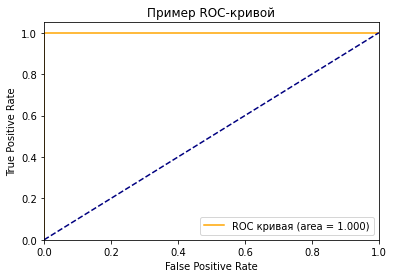

Номер класса: 1


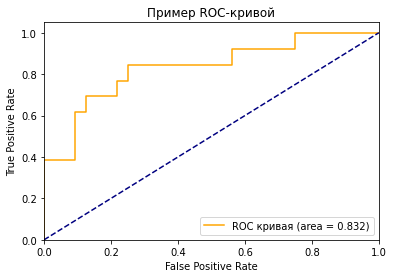

Номер класса: 2


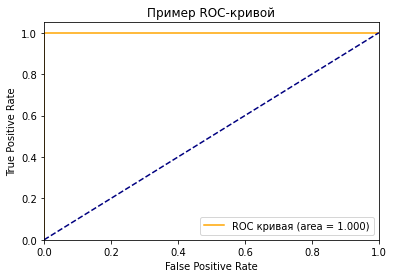

- на данных 'Iris plants dataset' будет с penalty = 'none', ratio = 'None', solver = 'newton-cg': 1.0


C:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Номер класса: 0


C:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


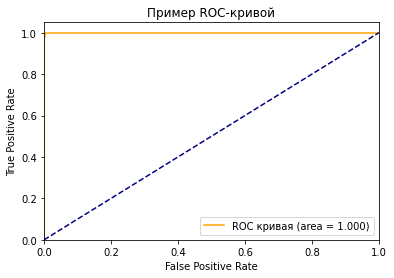

Номер класса: 1


C:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


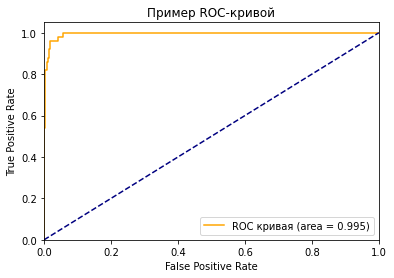

Номер класса: 2


C:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


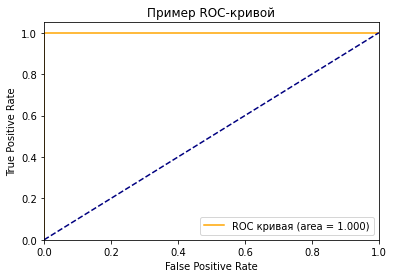

Номер класса: 3


C:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


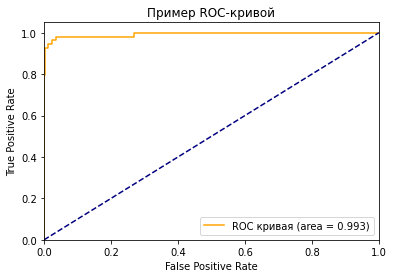

Номер класса: 4


C:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


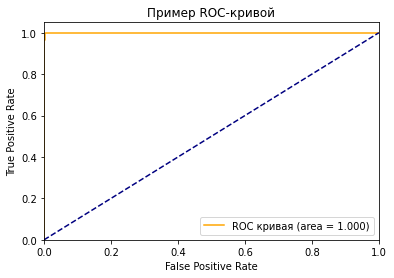

Номер класса: 5


C:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


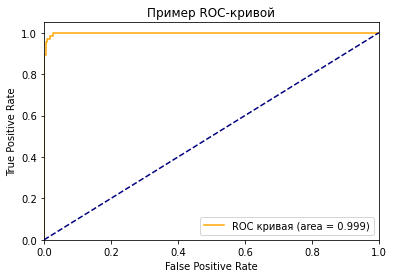

Номер класса: 6


C:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


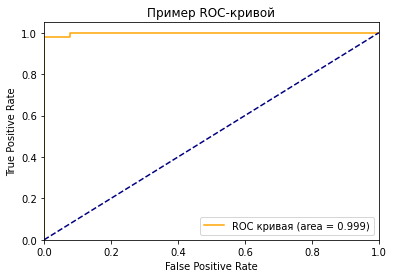

Номер класса: 7


C:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


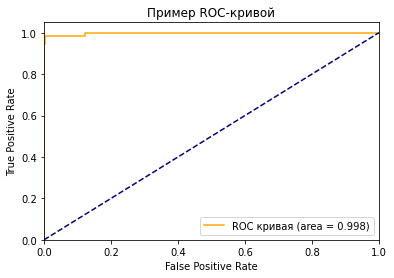

Номер класса: 8


C:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


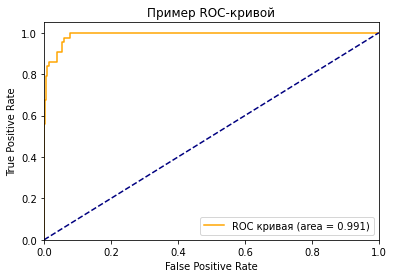

Номер класса: 9


C:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


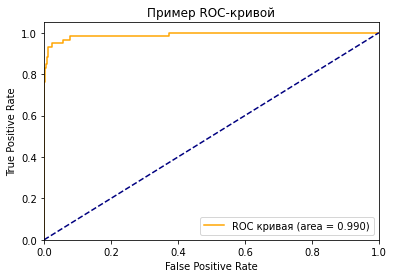

C:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (124). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "
C:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (54). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "


- на данных 'Optical recognition of handwritten digits dataset' будет с penalty = 'none', ratio = 'None', solver = 'sag': 0.9722222222222222


C:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Номер класса: 0


C:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


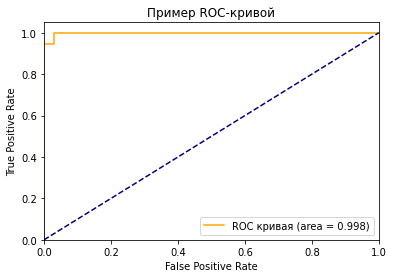

Номер класса: 1


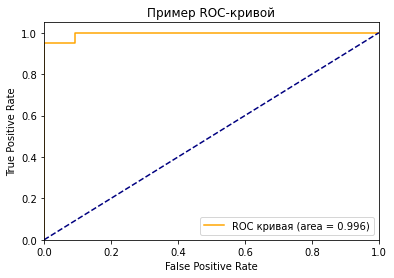

Номер класса: 2


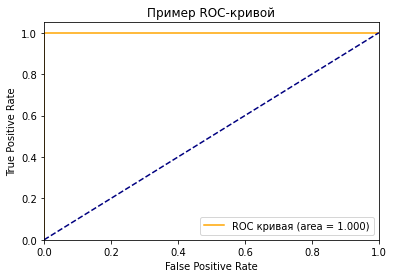

- на данных 'Wine recognition dataset' будет с penalty = 'l1', ratio = 'None', solver = 'newton-cg': 1.0


C:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (398). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "
C:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (171). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "
C:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the

Номер класса: 0


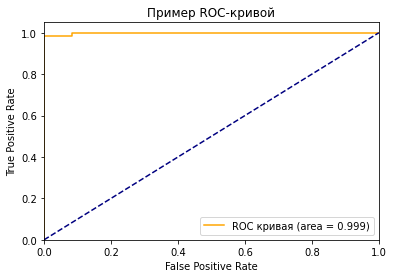

Номер класса: 1


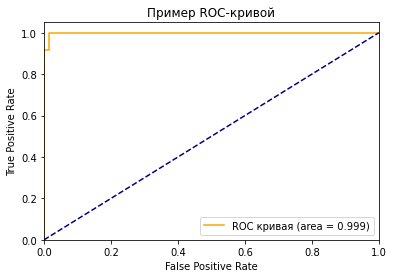

- на данных 'Breast cancer wisconsin (diagnostic) dataset' будет с penalty = 'l2', ratio = 'None', solver = 'newton-cg': 0.9941520467836257


In [104]:
if __name__ == "__main__":
    main()